In [1]:
from ColorExtractor import post
from ColorExtractor import tools
import re
import typer
res = [int(s) for s in re.findall(
    r'\d+', "8756_8768_12124_12137_z15_t110400")]
# print(res)
zoom = res[4]
# print(res[0], res[2])
# print(res[1], res[3])
NW_lat, NW_lng = post.num2deg(res[0], res[2]-1, zoom)
SE_lat, SE_lng = post.num2deg(res[1]+1, res[3], zoom)
# print(NW_lat, NW_lng)
# print(SE_lat, SE_lng)

# Estabilish the size of the image
X = SE_lng - NW_lng 
Y = SE_lat - NW_lat

In [2]:
import pandas as pd
filename = 'VED_181003_week'
_input = pd.read_csv('./ved_data_enrichment/data/ved-final/'+filename+'.csv',
                             dtype={"Latitude[deg]": float, 'Longitude[deg]': float,
                                    'Vehicle Speed[km/h]': float, 'Speed Limit[km/h]': 'string'},
                             nrows=1000)
_input.head()

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],...,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Match Type,Class of Speed Limit,Speed Limit[km/h],Speed Limit with Direction[km/h],Intersection,Focus Points,Bus Stops
0,337.031765,135.0,2253.0,0.0,42.272892,-83.74937,35.0,3.67,1062.0,14.117647,...,0.000948,42.272891,-83.749365,0,0.0,40,40.0,NaN,NaN,crossing
1,337.031765,135.0,2253.0,500.0,42.272892,-83.74937,35.0,9.46,1320.0,14.117647,...,0.002443,42.272891,-83.749365,1,0.0,40,40.0,NaN,NaN,crossing
2,337.031765,135.0,2253.0,1100.0,42.272892,-83.74937,34.0,9.46,1320.0,14.117647,...,0.002373,42.272891,-83.749365,1,0.0,40,40.0,NaN,NaN,crossing
3,337.031765,135.0,2253.0,2600.0,42.272892,-83.74937,33.0,11.48,1500.0,14.117647,...,0.002795,42.272891,-83.749365,1,0.0,40,40.0,NaN,NaN,crossing
4,337.031765,135.0,2253.0,3100.0,42.272633,-83.74945,33.0,11.48,1500.0,14.117647,...,0.002795,42.272633,-83.749450,0,-1.0,40-48,40.0,NaN,NaN,NaN


First point:  1248 1729
point delta:  {(-13, 1), (-22, 2), (-30, 5), (0, 0)}
Max delta:  30
Kernel size:  (31, 31)
Image size:  (62, 62)


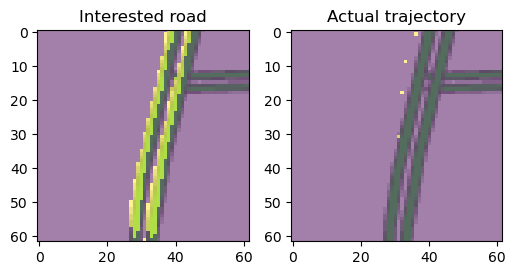

In [3]:
_input = _input[['DayNum', 'Latitude[deg]', 'Longitude[deg]', 'Vehicle Speed[km/h]', 'Speed Limit[km/h]']]
_input['Speed Limit[km/h]'] = pd.to_numeric(_input['Speed Limit[km/h]'], errors='coerce')
_input = _input.assign(Color_code='-1')
_input['Index'] = _input['DayNum'].apply(post.timeCalc)

for index, row in _input.iterrows():
# if(chunk['Vehicle Speed[km/h]'].at[index] / chunk['Speed Limit[km/h]'].at[index] >= 0.9):
#     continue  
    index = 59
    if index > 18:
        longitude_seq = []
        latitude_seq = []
        for i in range(12):
            # Change every 6 items
            new_index = index
            longitude_seq.append((_input['Longitude[deg]'].at[index - i] - NW_lng)/X)
            latitude_seq.append((_input['Latitude[deg]'].at[index - i] - NW_lat)/Y)
        _input['Color_code'].at[index] = tools.image_process_position_seq(longitude_seq, latitude_seq, _input['Index'].at[index])
        break
    else:
        _input['Color_code'].at[index] = tools.image_process(
            (_input['Longitude[deg]'].at[index] - NW_lng)/X,
            (_input['Latitude[deg]'].at[index] -NW_lat)/Y,
            _input['Index'].at[index])
        break